In [1]:
import os
import numpy as np
import trimesh
import pyrender
import h5py
from mesh_to_png import mesh_to_png
from landmarks import detect_landmark
from data_def import PCAModel, Mesh
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
import torch.nn as nn
from torch.autograd import Variable
from collections import namedtuple


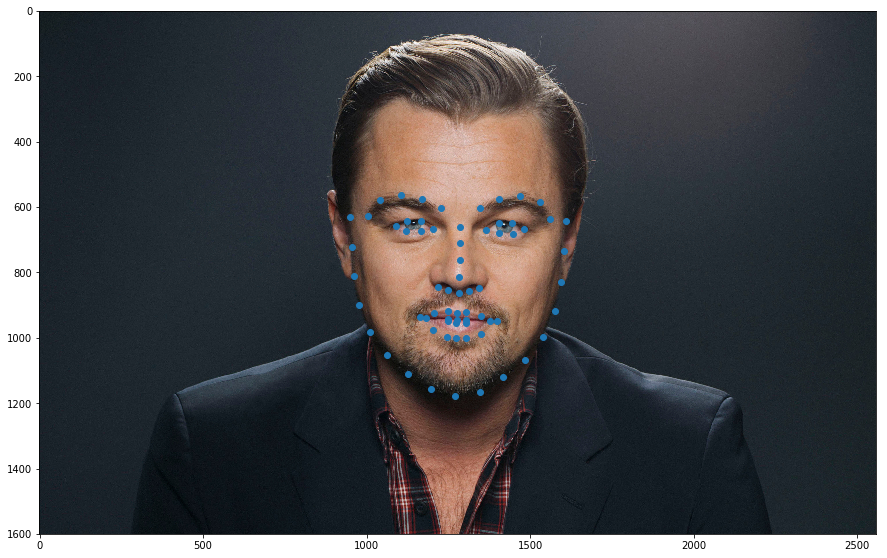

In [2]:
face_image = mpimg.imread('leo.jpg')
# face_image = (doge_image[:, :, :3] * 256).astype(np.uint8)
face_landmarks_gt = detect_landmark(face_image)
H, W = face_image.shape[0], face_image.shape[1]

fig = plt.figure(figsize = (15,10))
plt.imshow(face_image)
plt.scatter(face_landmarks_gt[:, 0], face_landmarks_gt[:, 1])
plt.axes().set_aspect('equal')
plt.show()
fig.savefig('results/face_landmarks_gt.png')

In [3]:
def load_bfm(N_id, N_exp):
    bfm = h5py.File("model2017-1_face12_nomouth.h5", 'r')
    mean_tex = np.asarray(bfm['color/model/mean'], dtype=np.float32).reshape((-1, 3))
    triangles = np.asarray(bfm['shape/representer/cells'], dtype=np.int32).T
    # PCA model for facial identity.
    mu_id = np.asarray(bfm['shape/model/mean'], dtype=np.float32).reshape((-1, 3))
    pcaBasis_id = np.asarray(bfm['shape/model/pcaBasis'], dtype=np.float32).reshape((-1, 3, 199))
    pcaVariance_id = np.asarray(bfm['shape/model/pcaVariance'], dtype=np.float32)
    # PCA model for expression.
    mu_exp = np.asarray(bfm['expression/model/mean'], dtype=np.float32).reshape((-1, 3))
    pcaBasis_exp = np.asarray(bfm['expression/model/pcaBasis'], dtype=np.float32).reshape((-1, 3, 100))
    pcaVariance_exp = np.asarray(bfm['expression/model/pcaVariance'], dtype=np.float32)

    # Pick the largest N_id and N_exp principal components and variances for facial identity and expressions respectively.
    E_id = pcaBasis_id[:, :, :N_id]
    E_exp = pcaBasis_exp[:, :, :N_exp]
    sigma_id = np.sqrt(pcaVariance_id[:N_id])
    sigma_exp = np.sqrt(pcaVariance_exp[:N_exp])

    # Convert all to PyTorch tensors.
    mu_id_torch = torch.Tensor(mu_id)
    mu_exp_torch = torch.Tensor(mu_exp)
    E_id_torch = torch.Tensor(E_id)
    E_exp_torch = torch.Tensor(E_exp)
    sigma_id_torch = torch.Tensor(sigma_id)
    sigma_exp_torch = torch.Tensor(sigma_exp)
    return mu_id_torch, mu_exp_torch, E_id_torch, E_exp_torch, sigma_id_torch, sigma_exp_torch

def load_landmark_inds():
    # Read facial landmark indices.
    landmarks=[]
    with open('Landmarks68_model2017-1_face12_nomouth.anl','r') as f:
        for line in f.readlines():
            landmarks.append(int(line.split('\n')[0]))
    landmarks = torch.tensor(landmarks)
    return landmarks

def Projection(W, H, f, n, fovy):
    # Define camera projection matrices.
    V = torch.Tensor([[W/2, 0, 0, W/2],
                      [0, -H/2, 0, H/2],
                      [0, 0, 0.5, 0.5],
                      [0, 0, 0, 1]
                     ])

    aspect_ratio = W / H
    t = np.tan(fovy / 2) * n
    b = -t
    r = t * aspect_ratio
    l = -t * aspect_ratio
    P = torch.Tensor([[(2*n)/(r-l),0,(r+l)/(r-l),0],
                  [0,(2*n)/(t-b),(t+b)/(t-b),0],
                  [0,0,-(f+n)/(f-n),-(2*f*n)/(f-n)],
                  [0,0,-1,0]])
    return V, P
def Rotation(omega):
    # Define Rotation matrix.
    Rx, Ry, Rz = torch.zeros(3, 3), torch.zeros(3, 3), torch.zeros(3, 3)
    Rx[0, 0] = 1.
    Rx[1, 1] = torch.cos(omega[0])
    Rx[1, 2] = -torch.sin(omega[0])
    Rx[2, 1] = torch.sin(omega[0])
    Rx[2, 2] = torch.cos(omega[0])

    Ry[0, 0] = torch.cos(omega[1])
    Ry[0, 2] = torch.sin(omega[1])
    Ry[1, 1] = 1.
    Ry[2, 0] = -torch.sin(omega[1])
    Ry[2, 2] = torch.cos(omega[1])
    
    Rz[0, 0] = torch.cos(omega[2])
    Rz[0, 1] = -torch.sin(omega[2])
    Rz[1, 0] = torch.sin(omega[2])
    Rz[1, 1] = torch.cos(omega[2])
    Rz[2, 2] = 1.
    
    R = Rx @ Ry @ Rz    
    return R

params = namedtuple('params', ['N_id', 'N_exp', 'epochs', 'lambda_alpha', 'lambda_delta', 'far', 'near', 'fovy', 'uni'])
outputs = namedtuple('outputs', ['losses_land', 'losses_reg', 'pred_landmark', 'G', 'V', 'P', 'T', 'alpha', 'delta', 'omega', 't'])

def train(params, face_landmarks_gt):
    # Extract parameters.
    N_id = params.N_id
    N_exp = params.N_exp
    epochs = params.epochs
    lambda_alpha = params.lambda_alpha
    lambda_delta = params.lambda_delta
    far = params.far
    near = params.near
    fovy = params.fovy
    uni = params.uni
    
    # Read Basel Face Model.
    mu_id_torch, mu_exp_torch, E_id_torch, E_exp_torch, sigma_id_torch, sigma_exp_torch = load_bfm(N_id, N_exp)
    landmarks = load_landmark_inds()

    # Define groundtruth facial landmarks.
    gt_landmark = torch.Tensor(face_landmarks_gt).t()

    # Initialize trainable variables.
    alpha = Variable(torch.FloatTensor(N_id).uniform_(-uni, uni), requires_grad=True)
    delta = Variable(torch.FloatTensor(N_exp).uniform_(-uni, uni), requires_grad=True)
#     alpha = Variable(torch.randn(N_id), requires_grad=True)
#     delta = Variable(torch.randn(N_exp), requires_grad=True)
    omega = Variable(torch.zeros(3), requires_grad=True)
    t = Variable(torch.Tensor([0, 0, -400]), requires_grad=True)

    # Initialize optimizer.
    opt = torch.optim.Adam([alpha, delta, omega, t], lr=0.1)

    # Define camera projection matrices.
    V, P = Projection(W, H, far, near, fovy)

    # Working quite good as well.
    # n = 300.
    # f = 2000.
    # fovy = 0.5
    # e = 1 / np.tan(fovy / 2)
    # a = H / W
    # P = torch.Tensor([[e, 0, 0, 0],
    #                   [0, e/a, 0, 0],
    #                   [0, 0, -(f + n)/(f-n), -2*f*n/(f - n)],
    #                   [0, 0, -1, 0]
    #                  ])

    losses_land = []
    losses_reg = []

    for epoch in np.arange(epochs):
        opt.zero_grad()    
        G = mu_id_torch + E_id_torch @ (alpha * sigma_id_torch) + mu_exp_torch + E_exp_torch @ (delta * sigma_exp_torch)    
        G_landmark_tmp = torch.transpose(torch.index_select(G, 0, landmarks), 0, 1)
        G_landmark = torch.cat((G_landmark_tmp, torch.ones(1, len(landmarks))), 0)

        # Define the Rotation matrix.
        R = Rotation(omega)

        # Define the Translation matrix.
        T = torch.cat((torch.cat((R, t.view(-1, 1)), dim=1), torch.tensor([0., 0., 0., 1.]).view(1, -1)), dim=0)   

        out = V @ P @ T @ G_landmark
        pred_landmark = torch.empty_like(gt_landmark)
        # Divide by the homogeneous dimension.
        pred_landmark[0, :] = out[0, :] / out[3, :]
        pred_landmark[1, :] = out[1, :] / out[3, :]

        L_landmark = (pred_landmark - gt_landmark).pow(2).sum(dim=0).sqrt().sum()
        L_regularizer = lambda_alpha * alpha.pow(2).sum() + lambda_delta * delta.pow(2).sum()
        L_fit = L_landmark + L_regularizer
        L_fit.backward(retain_graph=True)
        opt.step()    
        losses_land.append(L_landmark.item())
        losses_reg.append(L_regularizer)
        print('Epoch: {}, L_landmark: {:.3f}, L_regularizer: {:.3f}'.format(epoch, L_landmark, L_regularizer))    
    return outputs(losses_land, losses_reg, pred_landmark, G, V, P, T, alpha, delta, omega, t)

In [4]:
# Define Hyperparameters.
N_id = 30
N_exp = 20
epochs = 500
lambda_alpha = 1
lambda_delta = 1
far = 2000.
near = 300.
fovy = 0.5
uni = 1
train_params = params(N_id, N_exp, epochs, lambda_alpha, lambda_delta, far, near, fovy, uni)

# Train.
train_outputs = train(train_params, face_landmarks_gt)
losses_land = train_outputs.losses_land
losses_reg = train_outputs.losses_reg 
pred_landmark = train_outputs.pred_landmark
G = train_outputs.G
V = train_outputs.V 
P = train_outputs.P
T = train_outputs.T
alpha = train_outputs.alpha
delta = train_outputs.delta
omega = train_outputs.omega
t = train_outputs.t


Epoch: 0, L_landmark: 19153.096, L_regularizer: 74.917
Epoch: 1, L_landmark: 19513.164, L_regularizer: 74.901
Epoch: 2, L_landmark: 18527.607, L_regularizer: 74.569
Epoch: 3, L_landmark: 18063.443, L_regularizer: 74.895
Epoch: 4, L_landmark: 17278.256, L_regularizer: 75.856
Epoch: 5, L_landmark: 16835.158, L_regularizer: 77.427
Epoch: 6, L_landmark: 16534.809, L_regularizer: 79.725
Epoch: 7, L_landmark: 16097.457, L_regularizer: 82.796
Epoch: 8, L_landmark: 15497.854, L_regularizer: 86.613
Epoch: 9, L_landmark: 15003.348, L_regularizer: 91.100
Epoch: 10, L_landmark: 14774.957, L_regularizer: 96.133
Epoch: 11, L_landmark: 14331.855, L_regularizer: 101.469
Epoch: 12, L_landmark: 13644.602, L_regularizer: 107.113
Epoch: 13, L_landmark: 13226.515, L_regularizer: 113.372
Epoch: 14, L_landmark: 12959.203, L_regularizer: 120.443
Epoch: 15, L_landmark: 12527.656, L_regularizer: 128.306
Epoch: 16, L_landmark: 11984.132, L_regularizer: 136.921
Epoch: 17, L_landmark: 11723.575, L_regularizer: 146

Epoch: 148, L_landmark: 896.891, L_regularizer: 395.539
Epoch: 149, L_landmark: 1189.546, L_regularizer: 393.960
Epoch: 150, L_landmark: 811.469, L_regularizer: 392.342
Epoch: 151, L_landmark: 1099.621, L_regularizer: 390.652
Epoch: 152, L_landmark: 820.965, L_regularizer: 388.900
Epoch: 153, L_landmark: 887.875, L_regularizer: 387.225
Epoch: 154, L_landmark: 1065.337, L_regularizer: 385.640
Epoch: 155, L_landmark: 804.483, L_regularizer: 384.090
Epoch: 156, L_landmark: 1168.594, L_regularizer: 382.541
Epoch: 157, L_landmark: 776.293, L_regularizer: 381.060
Epoch: 158, L_landmark: 1030.504, L_regularizer: 379.821
Epoch: 159, L_landmark: 785.758, L_regularizer: 378.567
Epoch: 160, L_landmark: 823.490, L_regularizer: 377.422
Epoch: 161, L_landmark: 964.450, L_regularizer: 376.363
Epoch: 162, L_landmark: 762.195, L_regularizer: 375.193
Epoch: 163, L_landmark: 1050.154, L_regularizer: 373.940
Epoch: 164, L_landmark: 800.686, L_regularizer: 372.729
Epoch: 165, L_landmark: 825.009, L_regular

Epoch: 295, L_landmark: 690.167, L_regularizer: 287.414
Epoch: 296, L_landmark: 737.379, L_regularizer: 287.046
Epoch: 297, L_landmark: 644.613, L_regularizer: 286.782
Epoch: 298, L_landmark: 684.030, L_regularizer: 286.625
Epoch: 299, L_landmark: 695.588, L_regularizer: 286.377
Epoch: 300, L_landmark: 630.825, L_regularizer: 286.248
Epoch: 301, L_landmark: 763.422, L_regularizer: 286.146
Epoch: 302, L_landmark: 640.730, L_regularizer: 285.904
Epoch: 303, L_landmark: 715.939, L_regularizer: 285.629
Epoch: 304, L_landmark: 711.932, L_regularizer: 285.322
Epoch: 305, L_landmark: 700.440, L_regularizer: 284.747
Epoch: 306, L_landmark: 747.884, L_regularizer: 284.057
Epoch: 307, L_landmark: 625.711, L_regularizer: 283.514
Epoch: 308, L_landmark: 689.213, L_regularizer: 283.111
Epoch: 309, L_landmark: 685.251, L_regularizer: 282.696
Epoch: 310, L_landmark: 643.597, L_regularizer: 282.585
Epoch: 311, L_landmark: 727.406, L_regularizer: 282.599
Epoch: 312, L_landmark: 610.877, L_regularizer: 

Epoch: 447, L_landmark: 580.977, L_regularizer: 264.548
Epoch: 448, L_landmark: 662.513, L_regularizer: 264.347
Epoch: 449, L_landmark: 591.446, L_regularizer: 264.213
Epoch: 450, L_landmark: 541.383, L_regularizer: 264.021
Epoch: 451, L_landmark: 547.021, L_regularizer: 263.796
Epoch: 452, L_landmark: 569.970, L_regularizer: 263.564
Epoch: 453, L_landmark: 638.101, L_regularizer: 263.263
Epoch: 454, L_landmark: 557.828, L_regularizer: 262.995
Epoch: 455, L_landmark: 544.954, L_regularizer: 262.806
Epoch: 456, L_landmark: 545.990, L_regularizer: 262.668
Epoch: 457, L_landmark: 624.992, L_regularizer: 262.604
Epoch: 458, L_landmark: 593.159, L_regularizer: 262.568
Epoch: 459, L_landmark: 557.485, L_regularizer: 262.509
Epoch: 460, L_landmark: 565.021, L_regularizer: 262.442
Epoch: 461, L_landmark: 606.056, L_regularizer: 262.331
Epoch: 462, L_landmark: 570.091, L_regularizer: 262.253
Epoch: 463, L_landmark: 598.896, L_regularizer: 262.204
Epoch: 464, L_landmark: 630.628, L_regularizer: 

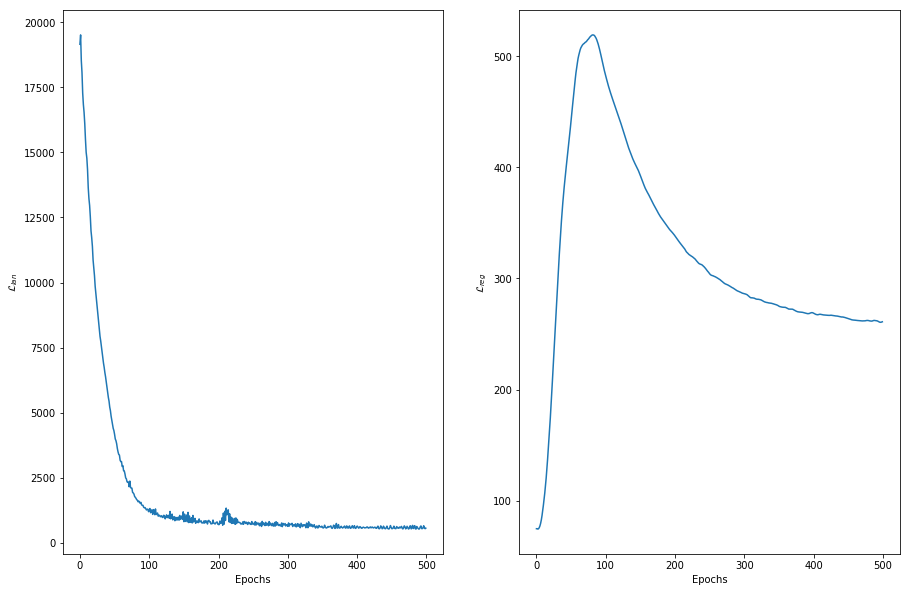

In [5]:
fig = plt.figure(figsize= (15, 10))
plt.subplot(1, 2, 1)
plt.plot(np.arange(epochs), losses_land)
plt.xlabel('Epochs')
plt.ylabel('$\mathcal{L}_{l a n}$')
plt.subplot(1, 2, 2)
plt.plot(np.arange(epochs), losses_reg)
plt.xlabel('Epochs')
plt.ylabel('$\mathcal{L}_{r e g}$')
plt.show()
fig.savefig('results/losses_uniform_{}.png'.format(str(uni).replace('.', '_')))

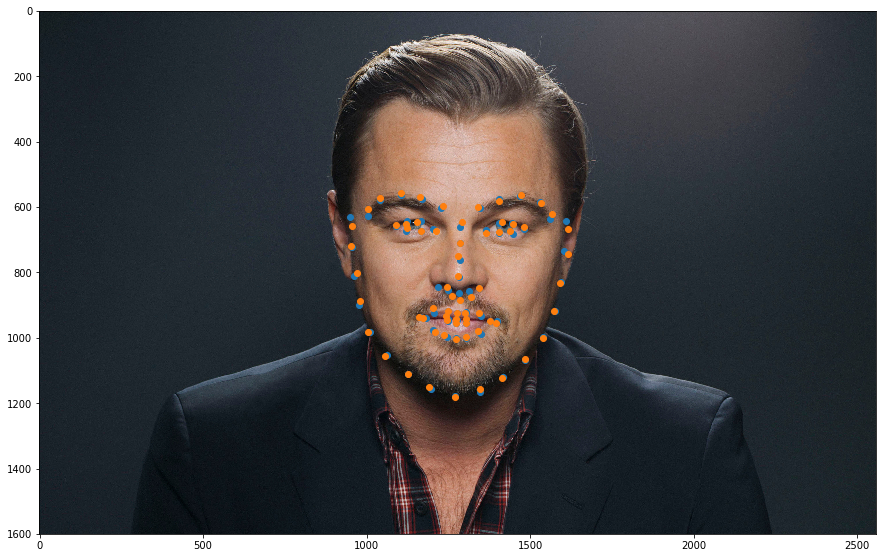

In [6]:
fig = plt.figure(figsize = (15,10))
plt.imshow(face_image)
plt.scatter(face_landmarks_gt[:, 0], face_landmarks_gt[:, 1])
plt.scatter(pred_landmark.detach().numpy()[0, :], pred_landmark.detach().numpy()[1, :])
plt.axes().set_aspect('equal')
plt.show()
fig.savefig('results/landmarks_matches_uniform_{}.png'.format(str(uni).replace('.', '_')))

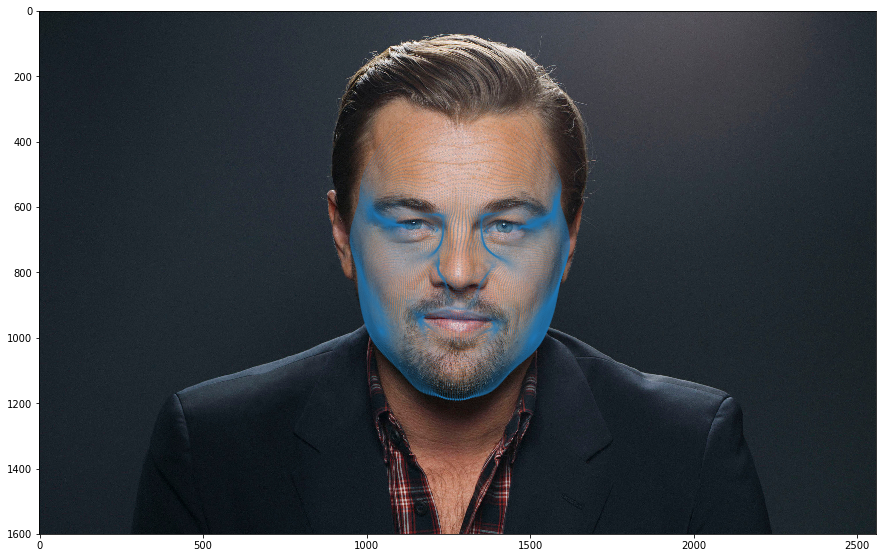

In [7]:
G_homo = torch.cat((G.t(), torch.ones(1, G.shape[0])), dim=0)
G_transformed = V @ P @ T @ G_homo

fig = plt.figure(figsize=(15, 10))
plt.imshow(face_image)
ax=fig.add_subplot(111)

ax.scatter(G_transformed.detach().numpy()[0, :] / G_transformed.detach().numpy()[3, :], G_transformed.detach().numpy()[1, :] / G_transformed.detach().numpy()[3, :], G_transformed.detach().numpy()[2, :] / G_transformed.detach().numpy()[3, :], marker='.')
plt.show()
fig.savefig('results/point_cloud_fit_uniform_{}.png'.format(str(uni).replace('.', '_')))